# **Project Goal, Plan, and Dataset**

# Customer Churn Modeling (Classification)

## Goal
The goal of this project is to predict customer churn for a retail bank dataset.

## Dataset
We use the dataset **Churn_Modelling.csv** (bank customer churn), where the target variable is:
- `Exited = 1`: customer churned (left the bank)
- `Exited = 0`: customer stayed

https://www.kaggle.com/datasets/shrutimechlearn/churn-modelling/data

Churn prediction is typically an **imbalanced classification problem**, therefore we do not rely on accuracy alone.
Instead, we prioritize metrics such as **precision/recall/F1 for the churn class**, as well as **ROC-AUC** and **PR-AUC**.



## Plan
1. Load and inspect the dataset.
2. Perform a short EDA (churn rate + a few distributions).
3. Preprocess data: encoding.
4. Train several models:
   - Logistic Regression
   - Random Forest
   - SVM (linear)
   - KNN
   - Gradient Boosting (with imbalance handled via sample weights)
5. Evaluate and compare models with churn-relevant metrics.
6. Perform cross-validation (StratifiedKFold) to validate robustness.
7. Tune the decision threshold for Gradient Boosting (0.2–0.4) to optimize churn detection.
8. Conclude which model is most suitable and why (including business meaning).

In [24]:
# Import necessary libraries and tools for the project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
    RocCurveDisplay,
    PrecisionRecallDisplay
)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils.class_weight import compute_sample_weight

sns.set_context("notebook") # Notebook-optimized plot context
sns.set_style('whitegrid') # Apply white grid style to improve plot clarity

# **Load Data & Basic Inspection**

In [80]:
df = pd.read_csv("Churn_Modelling.csv")

# Quick preview
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [81]:
# Data types and missing values overview
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [82]:
# Check duplicates
df[df.duplicated()]

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited


## Column overview and feature selection rationale

The dataset contains 10,000 bank customers and 14 columns.
No missing values were detected across all features.
Data types are consistent with their semantic meaning (numerical, categorical, binary).
No duplicated rows were found.

Overall, the dataset is clean and suitable for further analysis and modeling. Below is a short interpretation of the main fields:

- **RowNumber**: an index-like row identifier (technical, no business meaning).
- **CustomerId**: unique customer identifier (used for tracking, not predictive).
- **Surname**: customer last name (not a meaningful driver of churn).
- **CreditScore**: credit score of the customer.
- **Geography**: customer country/region (categorical).
- **Gender**: customer gender (categorical).
- **Age**: customer age.
- **Tenure**: number of years the customer has been with the bank.
- **Balance**: account balance.
- **NumOfProducts**: number of bank products used by the customer.
- **HasCrCard**: whether the customer has a credit card (binary).
- **IsActiveMember**: whether the customer is an active member (binary).
- **EstimatedSalary**: estimated salary.
- **Exited**: target variable (1 = churned, 0 = stayed).

### Why we do not use all columns as features
For churn prediction, we aim to use variables that reflect customer behavior and profile.
Therefore, we **exclude**:
- **RowNumber** (technical index),
- **CustomerId** (identifier),
- **Surname** (non-informative text identifier).

These columns do not carry causal or behavioral information about churn and may introduce noise or leakage-like patterns.
We keep the remaining variables as predictive features because they describe customer characteristics and engagement that can plausibly influence the probability of churn.


# **Short EDA**

## Target variable: Customer churn

We start by analyzing the target variable `Exited`, which indicates whether a customer has churned.
Understanding the churn rate is crucial, as churn prediction is typically an imbalanced classification problem.


Exited
0    7963
1    2037
Name: count, dtype: int64
Churn rate: 20.37%


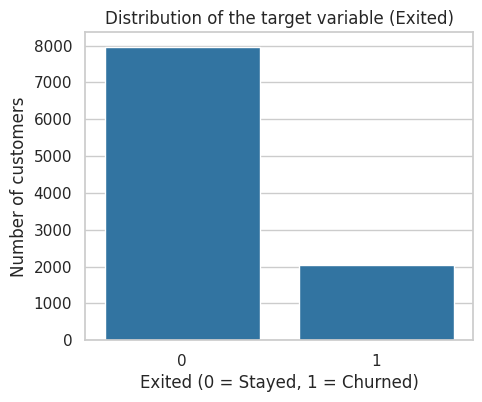

In [83]:
churn_counts = df["Exited"].value_counts()
churn_rate = df["Exited"].mean()

print(churn_counts)
print(f"Churn rate: {churn_rate:.2%}")

plt.figure(figsize=(5,4))
sns.countplot(x="Exited", data=df)
plt.title("Distribution of the target variable (Exited)")
plt.xlabel("Exited (0 = Stayed, 1 = Churned)")
plt.ylabel("Number of customers")
plt.show()


**Interpretation**

Approximately 20% of customers have churned, while around 80% remained with the bank.
This confirms a clear class imbalance, meaning that accuracy alone is not an appropriate performance metric.
Metrics such as recall, precision, F1-score, ROC-AUC, and PR-AUC are more informative for this task.

**Categorical features and their relationship with churn**

Next, we explore categorical and discrete variables to understand how churn is distributed across different customer groups.
We visualize each variable with respect to the churn outcome.


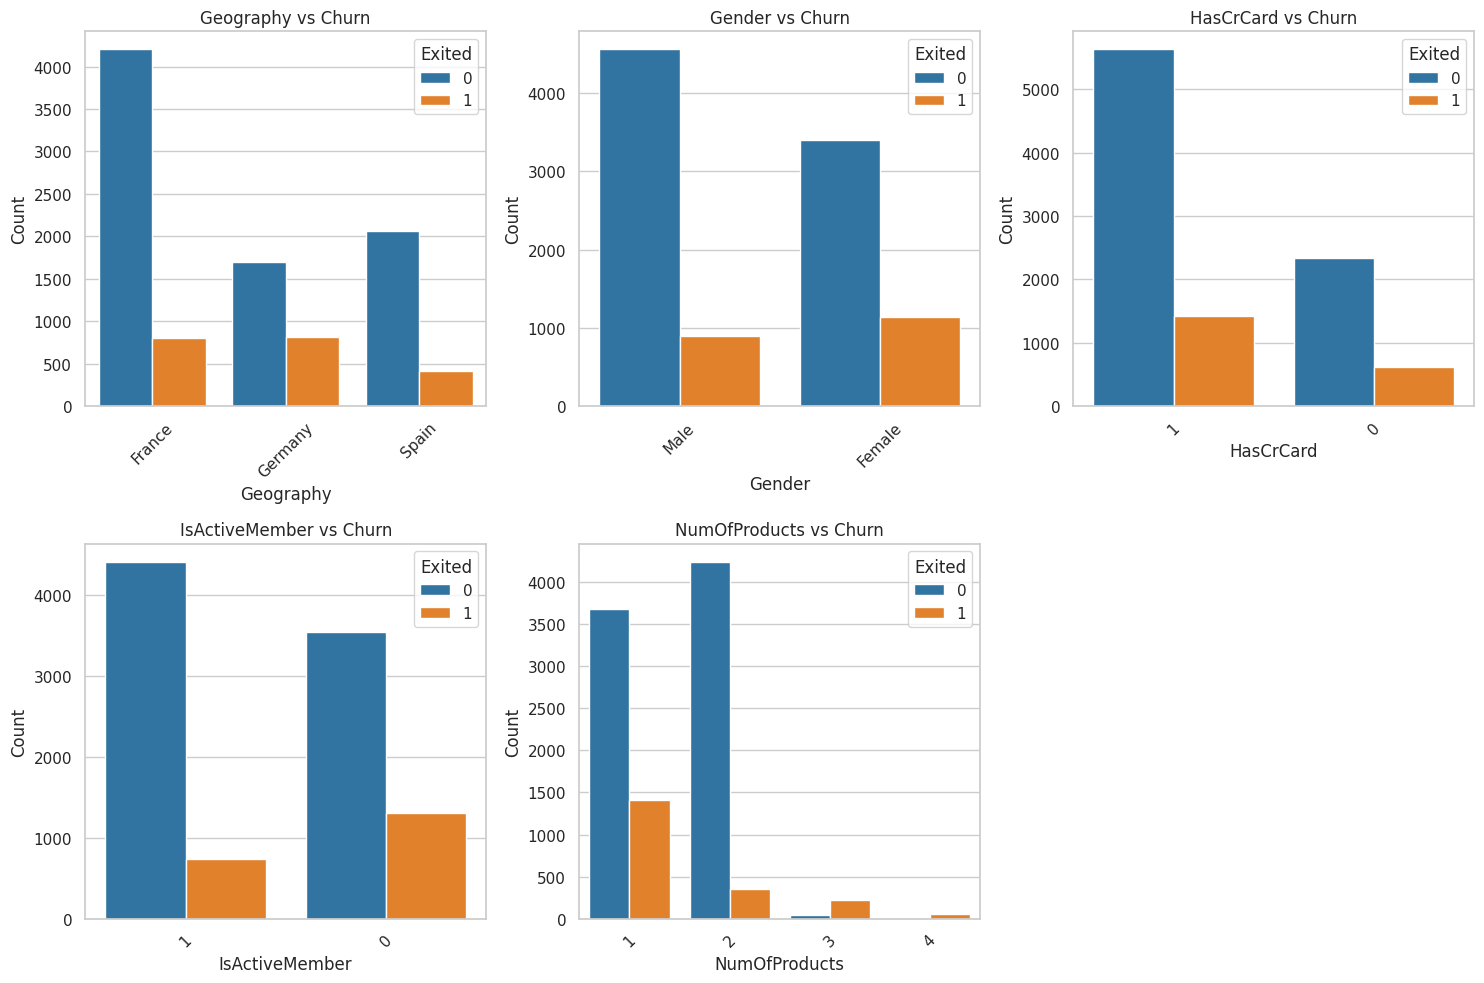

In [84]:
categorical_cols = [
    "Geography",
    "Gender",
    "HasCrCard",
    "IsActiveMember",
    "NumOfProducts"
]

plt.figure(figsize=(15, 10))

for i, col in enumerate(categorical_cols):
    plt.subplot(2, 3, i + 1)
    sns.countplot(
        data=df,
        x=col,
        hue="Exited",
        order=df[col].value_counts().index
    )
    plt.title(f"{col} vs Churn")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [85]:
churn_tables = {}

for col in categorical_cols:
    table = (
        df.groupby(col)["Exited"]
          .mean()
          .mul(100)
          .round(2)
          .reset_index(name="ChurnRate_%")
          .sort_values("ChurnRate_%", ascending=False)
    )
    churn_tables[col] = table
    print(f"\nChurn rate by {col}:")
    display(table)



Churn rate by Geography:


,Geography,ChurnRate_%
1,Germany,32.44
2,Spain,16.67
0,France,16.15



Churn rate by Gender:


,Gender,ChurnRate_%
0,Female,25.07
1,Male,16.46



Churn rate by HasCrCard:


,HasCrCard,ChurnRate_%
0,0,20.81
1,1,20.18



Churn rate by IsActiveMember:


,IsActiveMember,ChurnRate_%
0,0,26.85
1,1,14.27



Churn rate by NumOfProducts:


,NumOfProducts,ChurnRate_%
3,4,100.00
2,3,82.71
0,1,27.71
1,2,7.58


**Interpretation**

- Categorical analysis reveals several meaningful patterns.
- Churn rates vary significantly by geography, with customers from Germany exhibiting the highest churn.
- Customer activity level is a strong predictor, as inactive members churn substantially more often than active ones.
- The number of products shows a non-linear relationship with churn, where customers holding two products have the lowest churn rate, while higher product counts are associated with increased churn.
- Gender shows a moderate association with churn, whereas credit card ownership has minimal impact.

Overall, Geography, IsActiveMember, NumOfProducts, and Gender appear to be useful predictive features, while HasCrCard provides limited predictive value.

These insights justify the inclusion of these variables as predictive features in the modeling stage.


**Numerical feature distributions**

We now analyze key numerical variables to compare their distributions between churned and non-churned customers.
This helps identify differences in customer profiles that may drive churn.

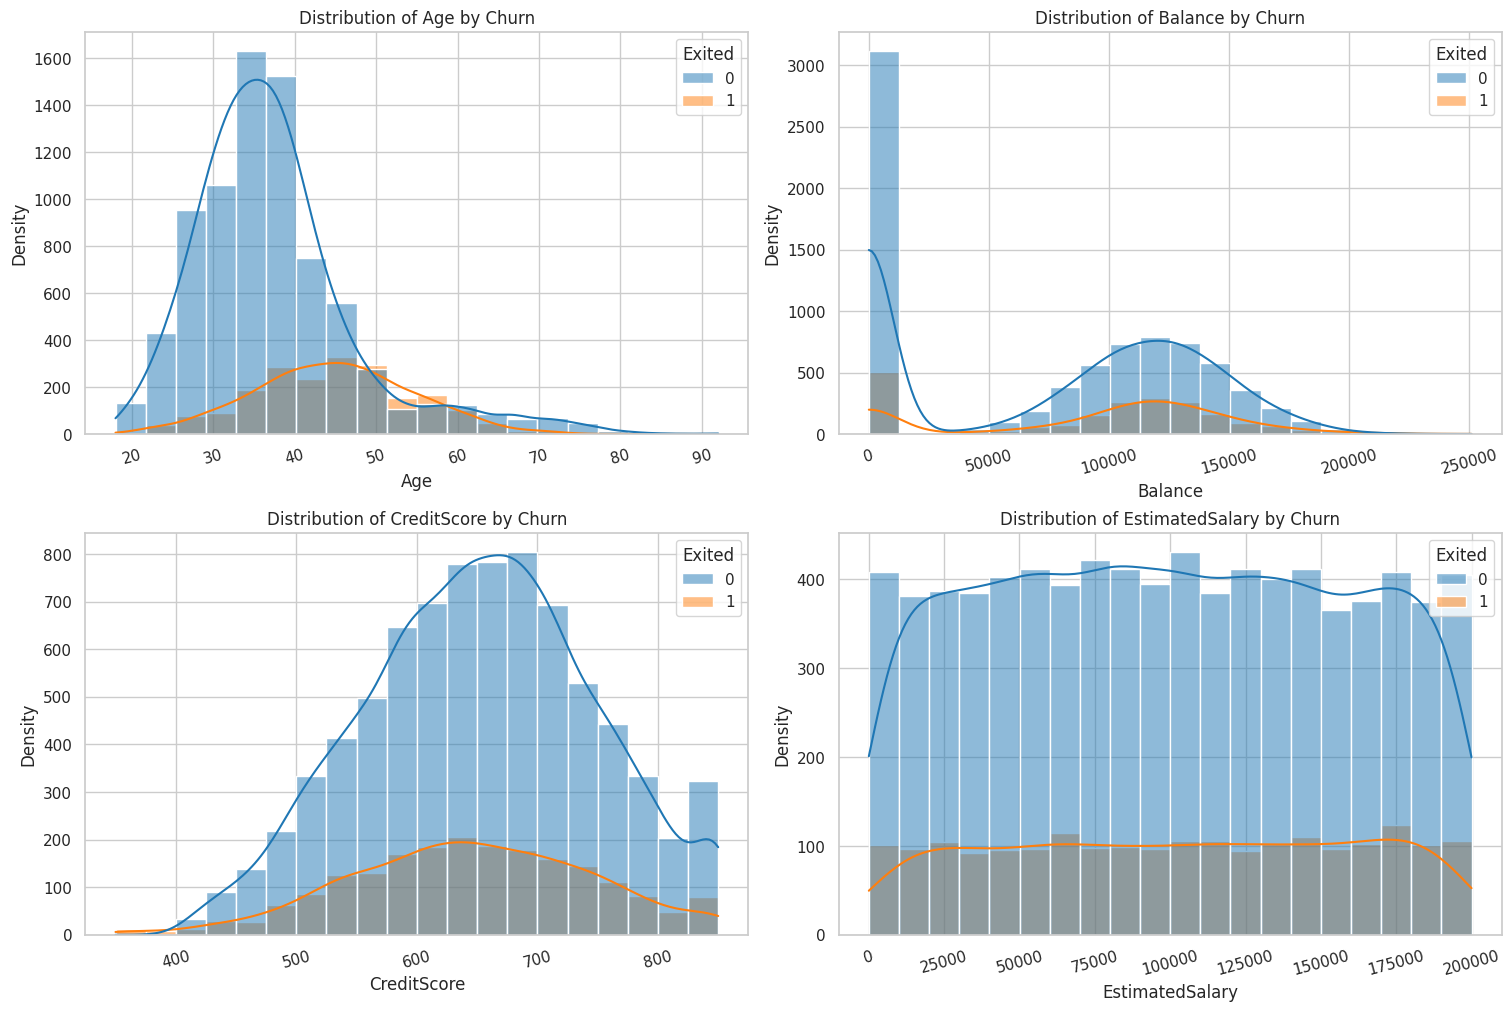

In [86]:
numerical_cols = [
    "Age",
    "Balance",
    "CreditScore",
    "EstimatedSalary"
]

fig, axes = plt.subplots(2, 2, figsize=(15, 10), constrained_layout=True)

for ax, col in zip(axes.flat, numerical_cols):
    sns.histplot(
        data=df,
        x=col,
        hue="Exited",
        kde=True,
        bins=20,
        ax=ax
    )
    ax.set_title(f"Distribution of {col} by Churn")
    ax.set_xlabel(col)
    ax.set_ylabel("Density")
    ax.tick_params(axis="x", rotation=15)

plt.show()


**Interpretation**

- Churned customers tend to be older on average than non-churned customers.
- Customers with higher account balances are more likely to churn, particularly compared to customers with zero balance.
- Credit score and estimated salary show weaker separation between churned and non-churned customers, suggesting a more limited standalone impact.


**EDA summary**

- The exploratory analysis reveals several important insights.
- The target variable is imbalanced, motivating the use of churn-focused evaluation metrics.
- Customer activity level, number of products, geography, age, and account balance demonstrate meaningful relationships with churn.
- These findings support the selected feature set and justify the use of models capable of capturing non-linear patterns.

Overall, the EDA provides a solid foundation for subsequent modeling and evaluation stages.


# **Preprocessing**

# Encoding
- `Gender` is binary → encoded with LabelEncoder.
- `Geography` is categorical with no natural ordering → one-hot encoded using get_dummies.
  We use `drop_first=True` to avoid multicollinearity in linear models (reference category is implicitly represented).

In [87]:
# Clean column names by removing leading/trailing spaces
df.columns = df.columns.str.strip()

# Encode binary categorical variable (Gender)
# Encode Gender: 0 = Female, 1 = Male
label_encoder = LabelEncoder()
df["Gender"] = label_encoder.fit_transform(df["Gender"])

# One-hot encode Geography and avoid dummy variable trap
df = pd.get_dummies(df, columns=["Geography"], drop_first=True)

# Preview transformed dataset
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain
0,1,15634602,Hargrave,619,0,42,2,0.00,1,1,1,101348.88,1,False,False
1,2,15647311,Hill,608,0,41,1,83807.86,1,0,1,112542.58,0,False,True
2,3,15619304,Onio,502,0,42,8,159660.80,3,1,0,113931.57,1,False,False
3,4,15701354,Boni,699,0,39,1,0.00,2,0,0,93826.63,0,False,False
4,5,15737888,Mitchell,850,0,43,2,125510.82,1,1,1,79084.10,0,False,True


# Feature Selection, Train/Test Split, and Scaling

# Feature Matrix and Train/Test Split
We define the feature set and split the dataset.
We use `stratify=y` to preserve churn ratio in both train and test sets.

Scaling:
- Scaling is important for Logistic Regression, SVM, and KNN.
- Tree-based models (Random Forest, Gradient Boosting) do not strictly require scaling,
  but we keep a consistent preprocessing for fair comparison.

In [88]:
# Select feature columns for model training
features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
            'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Gender',
            'Geography_Spain', 'Geography_Germany']

# Create feature matrix (X) and target vector (y)
X = df[features]
y = df['Exited']

In [89]:
# Train-test split with stratification on target
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # important for imbalanced classification
)

In [91]:
# Standardization (fit on train only to avoid test->train data leakage)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Preview scaled feature values
X_train_scaled[:2], X_test_scaled[:2]

(array([[ 1.058568  ,  1.71508648,  0.68472287, -1.22605881, -0.91025649,
          0.64104192, -1.030206  ,  1.04208392,  0.90750738, -0.57773517,
         -0.57831252],
        [ 0.91362605, -0.65993547, -0.6962018 ,  0.41328769, -0.91025649,
          0.64104192, -1.030206  , -0.62355635,  0.90750738, -0.57773517,
          1.72916886]]),
 array([[-0.68073539, -0.27993196,  0.68472287, -1.22605881,  0.80883036,
          0.64104192, -1.030206  , -0.09502138,  0.90750738, -0.57773517,
         -0.57831252],
        [-1.30191518, -0.5649346 , -0.35097064,  0.87711343,  0.80883036,
         -1.55996038, -1.030206  , -0.778941  ,  0.90750738, -0.57773517,
          1.72916886]]))

# Evaluation Helpers
We create helper functions to:
- print confusion matrix and classification report,
- compute ROC-AUC and PR-AUC (where probabilities or scores are available),
- optionally plot ROC and PR curves for selected best models.

In [93]:
def evaluate_classifier(name, y_true, y_pred, y_score=None):
    """
    Evaluate binary classification performance.

    Parameters:
    - name: model name (string)
    - y_true: true labels
    - y_pred: predicted class labels
    - y_score: predicted probabilities or decision scores for positive class
               (used to compute ROC-AUC and PR-AUC)
    """
    # Print model header
    print("=" * 70)
    print(f"Model: {name}\n")

    # Compute and display confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:\n", cm, "\n")

    # Print precision, recall, F1-score for each class
    print("Classification Report:\n", classification_report(y_true, y_pred))

    # Compute and print accuracy
    acc = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {acc:.4f}")

    # Compute ROC-AUC and PR-AUC if probability scores are provided
    if y_score is not None:
        roc = roc_auc_score(y_true, y_score)
        pr = average_precision_score(y_true, y_score)
        print(f"ROC-AUC: {roc:.4f}")
        print(f"PR-AUC:  {pr:.4f}")

    # Return confusion matrix for further analysis
    return cm

In [94]:
def compute_metrics(y_true, y_pred, y_score=None):
    """
    Compute key classification metrics for the positive class (Exited = 1).

    Parameters:
    - y_true: true labels
    - y_pred: predicted class labels
    - y_score: predicted probabilities or decision scores for class 1
               (used to compute ROC-AUC and PR-AUC)

    Returns:
    - Dictionary with precision, recall, F1 for class 1,
      and ROC-AUC / PR-AUC if available
    """
    # Precision, recall and F1-score for churn class (1)
    prec1 = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
    rec1  = recall_score(y_true, y_pred, pos_label=1, zero_division=0)
    f1    = f1_score(y_true, y_pred, pos_label=1, zero_division=0)

    # Initialize AUC metrics as NaN (in case y_score is not provided)
    roc = np.nan
    pr  = np.nan

    # Compute ROC-AUC and PR-AUC if probability scores are available
    if y_score is not None:
        roc = roc_auc_score(y_true, y_score)
        pr  = average_precision_score(y_true, y_score)

    # Return metrics as a dictionary (useful for model comparison tables)
    return {
        "precision_1": prec1,
        "recall_1": rec1,
        "f1_1": f1,
        "roc_auc": roc,
        "pr_auc": pr
    }

In [96]:
def print_basic_report(name, y_true, y_pred):
    """
    Print a standard classification report for a given model.
    """
    # Visual separator for readability
    print("=" * 70)
    print(f"Model: {name}")

    # Display confusion matrix
    print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))

    # Display precision, recall, F1-score for all classes
    print("\nClassification Report:\n", classification_report(y_true, y_pred))

    # Display overall accuracy
    print("Accuracy:", accuracy_score(y_true, y_pred))

# **Train & Evaluate Models**

# Random Forest

In [97]:
# Initialize Random Forest classifier
rf = RandomForestClassifier(
    n_estimators=100,          # Number of trees
    class_weight="balanced",   # Handle class imbalance
    random_state=42            # Reproducibility
)

# Train the model
rf.fit(X_train_scaled, y_train)

# Predict class labels on test set
y_pred_rf = rf.predict(X_test_scaled)

# Predict probabilities for positive class (Exited = 1)
y_score_rf = rf.predict_proba(X_test_scaled)[:, 1]

# Print evaluation report
print_basic_report("Random Forest", y_test, y_pred_rf)


Model: Random Forest

Confusion Matrix:
 [[1542   51]
 [ 230  177]]

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.97      0.92      1593
           1       0.78      0.43      0.56       407

    accuracy                           0.86      2000
   macro avg       0.82      0.70      0.74      2000
weighted avg       0.85      0.86      0.84      2000

Accuracy: 0.8595


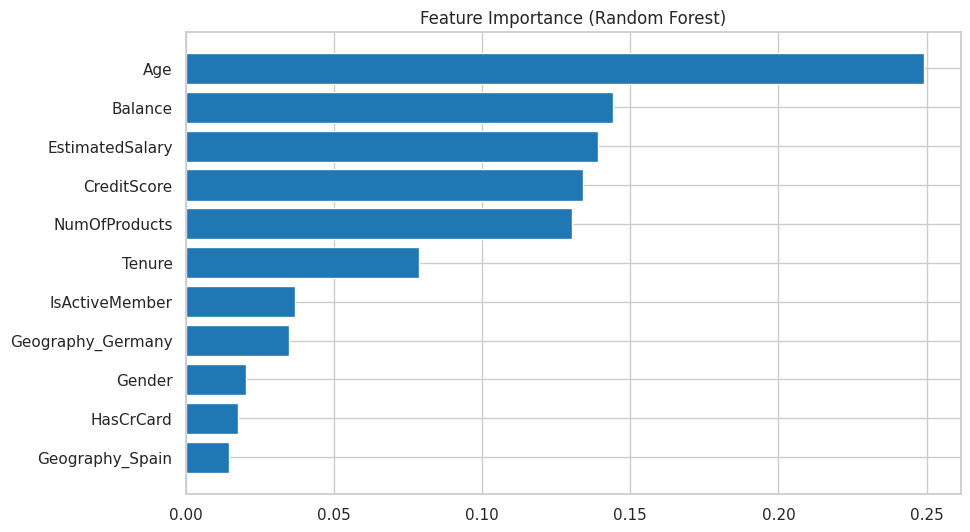

In [99]:
# Get feature importance scores from trained Random Forest
importances = rf.feature_importances_

# Sort features by importance (descending order)
indices = np.argsort(importances)[::-1]

# Get feature names in sorted order
names = [features[i] for i in indices]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importance (Random Forest)")
plt.barh(range(len(features)), importances[indices])
plt.yticks(range(len(features)), names)
plt.gca().invert_yaxis()  # Most important feature on top
plt.show()


# Logistic Regression model

In [101]:
# Initialize Logistic Regression model
log_reg = LogisticRegression(
    class_weight="balanced",  # Handle class imbalance
    random_state=42,          # Reproducibility
    max_iter=1000             # Ensure convergence
)

# Train the model on scaled features
log_reg.fit(X_train_scaled, y_train)

# Predict class labels on test set
y_pred_lr = log_reg.predict(X_test_scaled)

# Predict probabilities for positive class (Exited = 1)
y_score_lr = log_reg.predict_proba(X_test_scaled)[:, 1]

# Print evaluation report
print_basic_report("Logistic Regression", y_test, y_pred_lr)



Model: Logistic Regression

Confusion Matrix:
 [[1142  451]
 [ 122  285]]

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.72      0.80      1593
           1       0.39      0.70      0.50       407

    accuracy                           0.71      2000
   macro avg       0.65      0.71      0.65      2000
weighted avg       0.80      0.71      0.74      2000

Accuracy: 0.7135


# Support Vector Machine model (linear)

In [102]:
# Initialize linear SVM classifier
# probability=True enables predict_proba (needed for ROC/PR curves)
svm_model = SVC(
    kernel="linear",         # Linear kernel
    class_weight="balanced", # Handle class imbalance
    probability=True,        # Enable probability estimates
    random_state=42          # Reproducibility
)

# Train the model on scaled features
svm_model.fit(X_train_scaled, y_train)

# Predict class labels on test set
y_pred_svm = svm_model.predict(X_test_scaled)

# Predict probabilities for positive class (Exited = 1)
y_score_svm = svm_model.predict_proba(X_test_scaled)[:, 1]

# Print evaluation report
print_basic_report("SVM (linear)", y_test, y_pred_svm)


Model: SVM (linear)

Confusion Matrix:
 [[1153  440]
 [ 119  288]]

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.72      0.80      1593
           1       0.40      0.71      0.51       407

    accuracy                           0.72      2000
   macro avg       0.65      0.72      0.66      2000
weighted avg       0.80      0.72      0.74      2000

Accuracy: 0.7205


# KNN (k-Nearest Neighbors)

In [103]:
# Initialize KNN classifier
knn = KNeighborsClassifier(
    n_neighbors=5,      # Number of nearest neighbors
    weights="distance"  # Weight neighbors by distance
)

# Fit model on scaled training data
knn.fit(X_train_scaled, y_train)

# Predict class labels on test set
y_pred_knn = knn.predict(X_test_scaled)

# Predict probabilities for positive class (Exited = 1)
y_score_knn = knn.predict_proba(X_test_scaled)[:, 1]

# Print evaluation report
print_basic_report("KNN (k=5, distance)", y_test, y_pred_knn)


Model: KNN (k=5, distance)

Confusion Matrix:
 [[1506   87]
 [ 261  146]]

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.95      0.90      1593
           1       0.63      0.36      0.46       407

    accuracy                           0.83      2000
   macro avg       0.74      0.65      0.68      2000
weighted avg       0.81      0.83      0.81      2000

Accuracy: 0.826


# Gradient Boosting (imbalanced via sample_weight)

In [104]:
# Initialize Gradient Boosting classifier
gbm = GradientBoostingClassifier(
    n_estimators=100,   # Number of boosting stages
    random_state=42    # Reproducibility
)

# Compute sample weights to handle class imbalance
sample_w = compute_sample_weight(
    class_weight="balanced",
    y=y_train
)

# Train model with sample weights
gbm.fit(X_train_scaled, y_train, sample_weight=sample_w)

# Predict probabilities for positive class (Exited = 1)
y_score_gbm = gbm.predict_proba(X_test_scaled)[:, 1]

# Apply default classification threshold (0.5)
y_pred_gbm_default = (y_score_gbm >= 0.5).astype(int)

# Print evaluation report
print_basic_report(
    "Gradient Boosting (default threshold=0.5)",
    y_test,
    y_pred_gbm_default
)


Model: Gradient Boosting (default threshold=0.5)

Confusion Matrix:
 [[1291  302]
 [  98  309]]

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.81      0.87      1593
           1       0.51      0.76      0.61       407

    accuracy                           0.80      2000
   macro avg       0.72      0.78      0.74      2000
weighted avg       0.84      0.80      0.81      2000

Accuracy: 0.8


# Summary Table of Metrics (all models)

In [106]:
rows = []

# Collect evaluation metrics for each model
# RF
rows.append({"model": "Random Forest", **compute_metrics(y_test, y_pred_rf, y_score_rf)})

# LR
rows.append({"model": "Logistic Regression", **compute_metrics(y_test, y_pred_lr, y_score_lr)})

# SVM
rows.append({"model": "SVM (linear)", **compute_metrics(y_test, y_pred_svm, y_score_svm)})

# KNN
rows.append({"model": "KNN (k=5)", **compute_metrics(y_test, y_pred_knn, y_score_knn)})

# GBM (default threshold 0.5)
rows.append({"model": "Gradient Boosting (thr=0.5)", **compute_metrics(y_test, y_pred_gbm_default, y_score_gbm)})

metrics_df = pd.DataFrame(rows).sort_values(by=["f1_1", "recall_1"], ascending=False)
metrics_df


,model,precision_1,recall_1,f1_1,roc_auc,pr_auc
4,Gradient Boosting (thr=0.5),0.505728,0.759214,0.607073,0.869005,0.713519
0,Random Forest,0.776316,0.434889,0.557480,0.855008,0.679918
2,SVM (linear),0.395604,0.707617,0.507489,0.777764,0.451883
1,Logistic Regression,0.387228,0.700246,0.498688,0.777138,0.468007
3,KNN (k=5),0.626609,0.358722,0.456250,0.759980,0.532618


**Interpretation**

The final model was selected based on performance metrics that are most relevant for churn prediction, where class imbalance is present and correctly identifying churned customers is a priority.

Gradient Boosting demonstrates the strongest overall performance across key metrics. It achieves the highest recall for the churn class (0.76), indicating that it correctly identifies a larger proportion of customers who actually churned compared to other models. This is critical in churn modeling, as failing to detect churned customers typically carries a higher business cost than false positives.

In addition, Gradient Boosting attains the highest F1-score (0.61), reflecting the best balance between precision and recall. Its PR-AUC (0.71) is also the highest among all evaluated models, suggesting superior performance under class imbalance and more reliable ranking of high-risk customers. The model further achieves the highest ROC-AUC (0.87), indicating strong overall class separability.

While Random Forest shows substantially higher precision (0.78), its recall is considerably lower (0.43), meaning that a large portion of churned customers is missed. Logistic Regression and linear SVM achieve relatively high recall (~0.70) but suffer from low precision and lower PR-AUC, resulting in weaker overall performance. KNN underperforms across most metrics and is less suitable for scalable churn prediction.

Overall, Gradient Boosting provides the most robust and balanced performance across recall, F1-score, PR-AUC, and ROC-AUC, making it the most appropriate choice for the final churn prediction model.


# **Threshold Tuning**

# Threshold analysis for Gradient Boosting

In churn prediction, the default decision threshold of 0.5 may be too conservative,
as missing a churned customer (false negative) is often more costly than contacting
a non-churn customer (false positive).

Therefore, we evaluated alternative decision thresholds in the range 0.2–0.5
to examine whether recall for the churn class could be improved without a severe
loss in precision.


# Train/Validation split for tuning

In [113]:
# Split training data into train and validation sets
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_scaled, y_train,
    test_size=0.25,
    random_state=42,
    stratify=y_train
)

# Initialize Gradient Boosting model for tuning
gbm_tune = GradientBoostingClassifier(
    n_estimators=100,
    random_state=42
)

# Compute sample weights to handle class imbalance
w_tr = compute_sample_weight(
    class_weight="balanced",
    y=y_tr
)

# Train model on training subset
gbm_tune.fit(X_tr, y_tr, sample_weight=w_tr)

# Predict churn probabilities on validation set
val_score = gbm_tune.predict_proba(X_val)[:, 1]

# Search thresholds 0.2–0.5

In [118]:
# Define range of decision thresholds to evaluate
thresholds = np.arange(0.20, 0.51, 0.01)

best_thr = None
best_f1 = -1
best_stats = None

# Tune threshold to maximize F1-score for churn class on validation set
for thr in thresholds:
    # Convert probabilities to class labels using current threshold
    y_val_pred = (val_score >= thr).astype(int)

    # Compute churn-focused metrics
    stats = compute_metrics(y_val, y_val_pred, y_score=val_score)

    # Update best threshold based on F1-score
    if stats["f1_1"] > best_f1:
        best_f1 = stats["f1_1"]
        best_thr = thr
        best_stats = stats

# Report optimal threshold and corresponding validation metrics
print(f"Best threshold in [0.2, 0.5]: {best_thr:.2f}")
print("Validation metrics at best threshold:", best_stats)


Best threshold in [0.2, 0.5]: 0.50
Validation metrics at best threshold: {'precision_1': 0.5025553662691652, 'recall_1': 0.7248157248157249, 'f1_1': 0.5935613682092555, 'roc_auc': np.float64(0.8558905592803898), 'pr_auc': np.float64(0.6830521426563422)}


**Interpretation**

- Lower thresholds typically increase recall (catch more churners) but also increase false positives.
- Higher thresholds typically increase precision but may miss more churners.
- If the best threshold is **0.50**, it means the model’s probability estimates and the precision–recall trade-off are already well aligned with the default decision rule.  
  In that case, threshold tuning confirms that the default threshold is appropriate rather than indicating a need to change it.

# Refit GBM on full training set, evaluate on test with tuned threshold

In [119]:
gbm_final = GradientBoostingClassifier(n_estimators=100, random_state=42)
w_full = compute_sample_weight(class_weight="balanced", y=y_train)
gbm_final.fit(X_train_scaled, y_train, sample_weight=w_full)

test_score_gbm = gbm_final.predict_proba(X_test_scaled)[:, 1]
y_pred_gbm_tuned = (test_score_gbm >= best_thr).astype(int)

print_basic_report(f"Gradient Boosting (tuned thr={best_thr:.2f})", y_test, y_pred_gbm_tuned)


Model: Gradient Boosting (tuned thr=0.50)

Confusion Matrix:
 [[1291  302]
 [  98  309]]

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.81      0.87      1593
           1       0.51      0.76      0.61       407

    accuracy                           0.80      2000
   macro avg       0.72      0.78      0.74      2000
weighted avg       0.84      0.80      0.81      2000

Accuracy: 0.8


# Add tuned GBM to summary table

In [120]:
tuned_row = {"model": f"Gradient Boosting (thr={best_thr:.2f})", **compute_metrics(y_test, y_pred_gbm_tuned, test_score_gbm)}
metrics_df2 = pd.concat([metrics_df, pd.DataFrame([tuned_row])], ignore_index=True)
metrics_df2.sort_values(by=["f1_1", "recall_1"], ascending=False)

,model,precision_1,recall_1,f1_1,roc_auc,pr_auc
0,Gradient Boosting (thr=0.5),0.505728,0.759214,0.607073,0.869005,0.713519
5,Gradient Boosting (thr=0.50),0.505728,0.759214,0.607073,0.869005,0.713519
1,Random Forest,0.776316,0.434889,0.557480,0.855008,0.679918
2,SVM (linear),0.395604,0.707617,0.507489,0.777764,0.451883
3,Logistic Regression,0.387228,0.700246,0.498688,0.777138,0.468007
4,KNN (k=5),0.626609,0.358722,0.456250,0.759980,0.532618


# **Cross-validation for robustness (StratifiedKFold)**

To ensure model stability, we perform 5-fold stratified CV on the training set.
We report mean and standard deviation of ROC-AUC and PR-AUC.

Note:
- For GBM we handle imbalance using fold-specific sample weights.
- For other models we rely on class_weight='balanced' where supported.

# CV helper (manual, supports GBM sample weights)

In [125]:
def cv_auc_pr(model_name, model_builder, X, y, use_sample_weight=False, n_splits=5, random_state=42):
    # Stratified cross-validation to preserve class distribution
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    roc_scores = []
    pr_scores = []

    for train_idx, val_idx in skf.split(X, y):
        # Split data into training and validation folds
        X_tr, X_va = X[train_idx], X[val_idx]
        y_tr, y_va = y.iloc[train_idx], y.iloc[val_idx]

        # Build a fresh (unfitted) model for each fold
        model = model_builder()

        # Optionally apply sample weights to handle class imbalance
        if use_sample_weight:
            w_tr = compute_sample_weight(class_weight="balanced", y=y_tr)
            model.fit(X_tr, y_tr, sample_weight=w_tr)
        else:
            model.fit(X_tr, y_tr)

        # Obtain continuous scores for the positive class (Exited = 1)
        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(X_va)[:, 1]
        else:
            # Fallback for models without predict_proba
            y_score = model.decision_function(X_va)

        # Compute ROC-AUC and PR-AUC for the validation fold
        roc_scores.append(roc_auc_score(y_va, y_score))
        pr_scores.append(average_precision_score(y_va, y_score))

    # Return mean and standard deviation of metrics across folds
    return {
        "model": model_name,
        "roc_auc_mean": np.mean(roc_scores),
        "roc_auc_std": np.std(roc_scores),
        "pr_auc_mean": np.mean(pr_scores),
        "pr_auc_std": np.std(pr_scores),
    }

# Run CV for models

In [126]:
# Use scaled training features for all CV computations
X_tr_full = X_train_scaled
y_tr_full = y_train.reset_index(drop=True)

cv_results = []

# Logistic Regression
cv_results.append(cv_auc_pr(
    "Logistic Regression",
    lambda: LogisticRegression(class_weight="balanced", random_state=42, max_iter=1000),
    X_tr_full, y_tr_full,
    use_sample_weight=False
))

# Random Forest
cv_results.append(cv_auc_pr(
    "Random Forest",
    lambda: RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42),
    X_tr_full, y_tr_full,
    use_sample_weight=False
))

# Linear SVM
cv_results.append(cv_auc_pr(
    "SVM (linear)",
    lambda: SVC(kernel="linear", class_weight="balanced", probability=True, random_state=42),
    X_tr_full, y_tr_full,
    use_sample_weight=False
))

# K-Nearest Neighbors
cv_results.append(cv_auc_pr(
    "KNN (k=5)",
    lambda: KNeighborsClassifier(n_neighbors=5, weights="distance"),
    X_tr_full, y_tr_full,
    use_sample_weight=False
))

# Gradient Boosting with balanced sample weights
cv_results.append(cv_auc_pr(
    "Gradient Boosting (sample_weight balanced)",
    lambda: GradientBoostingClassifier(n_estimators=100, random_state=42),
    X_tr_full, y_tr_full,
    use_sample_weight=True
))

# Aggregate CV results and rank models by PR-AUC
cv_df = pd.DataFrame(cv_results).sort_values(by="pr_auc_mean", ascending=False)
cv_df

,model,roc_auc_mean,roc_auc_std,pr_auc_mean,pr_auc_std
4,Gradient Boosting (sample_weight balanced),0.863952,0.011192,0.696268,0.023014
1,Random Forest,0.850794,0.010604,0.661500,0.018591
3,KNN (k=5),0.772353,0.016886,0.528845,0.037053
0,Logistic Regression,0.766204,0.020542,0.456809,0.028541
2,SVM (linear),0.767730,0.020792,0.441988,0.026077


**Interpretation**

Cross-validation results indicate that Gradient Boosting delivers the strongest and most stable performance for churn prediction. It achieves the highest mean ROC-AUC and PR-AUC, with relatively low standard deviation across folds, demonstrating both strong class separability and robustness under class imbalance. Random Forest ranks second, showing competitive ROC-AUC but lower PR-AUC, indicating weaker performance in identifying churned customers. Logistic Regression, linear SVM, and KNN exhibit substantially lower PR-AUC values, suggesting limited effectiveness in ranking high-risk churn cases. Overall, Gradient Boosting emerges as the most reliable model based on cross-validated performance.


# **ROC & PR curves for the best models**

# ROC and Precision-Recall Curves (Selected Models)
We visualize ROC and PR curves for the strongest candidates.
PR curve is particularly informative under class imbalance.

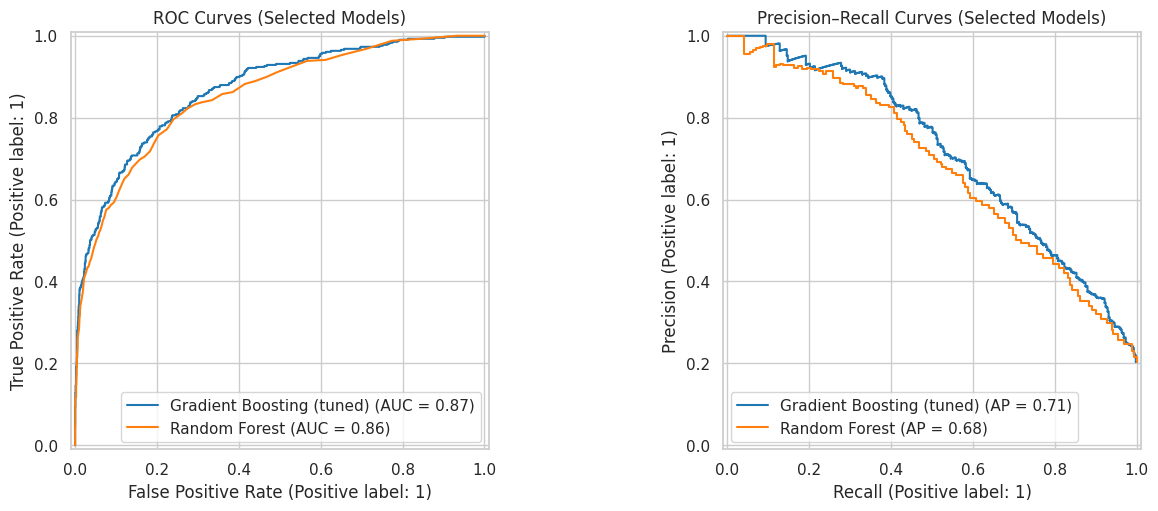

In [131]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5), constrained_layout=True)

# --- ROC Curves ---
for name, score in top_models_scores:
    RocCurveDisplay.from_predictions(
        y_test,
        score,
        name=name,
        ax=axes[0]
    )
axes[0].set_title("ROC Curves (Selected Models)")

# --- Precision-Recall Curves ---
for name, score in top_models_scores:
    PrecisionRecallDisplay.from_predictions(
        y_test,
        score,
        name=name,
        ax=axes[1]
    )
axes[1].set_title("Precision–Recall Curves (Selected Models)")

plt.show()


**Interpretation**

Both models demonstrate strong discriminative ability, with Gradient Boosting slightly outperforming Random Forest. The ROC curves show a higher AUC for Gradient Boosting (0.87 vs. 0.86), indicating marginally better class separability. More importantly for churn prediction, the Precision–Recall curves highlight a clearer advantage for Gradient Boosting, which achieves a higher average precision (0.71 vs. 0.68). This suggests that Gradient Boosting is more effective at identifying churned customers across different recall levels, making it the preferred model for this imbalanced classification task.

# **Interpretation & Conclusion**

# Interpretation and Conclusion

## Model comparison (churn-focused)
Accuracy can be misleading in churn prediction due to class imbalance.
Therefore, we compare models using:
- Precision(1): how many predicted churners are truly churners
- Recall(1): how many true churners are detected (critical for retention use-cases)
- F1(1): balance between precision and recall
- ROC-AUC and PR-AUC: threshold-independent performance measures

## Why Gradient Boosting
Gradient Boosting achieved the best overall trade-off for churn:
- High recall for the churn class (fewer missed churners),
- Competitive PR-AUC / ROC-AUC,
- Good generalization confirmed by cross-validation.

## Business meaning of Recall
In retention campaigns, missing a churner (false negative) often has higher cost than contacting a non-churner (false positive).
Thus, improving recall for class 1 increases the number of customers we can target for retention actions, potentially reducing churn.

## Final outcome: were the tasks achieved?
Yes.
We performed data loading, preprocessing, short EDA, trained multiple models, compared them with churn-relevant metrics,
validated robustness via stratified cross-validation, tuned the decision threshold for Gradient Boosting,
and provided a justified final model choice with business interpretation.
